# Aprenentatge profund per a imatges

A les lliçons anteriors, hem treballat extensament amb **dades tabulars**. Aquests conjunts de dades són generalment fàcils de representar i analitzar utilitzant eines com `pandas`, `scikit-learn` i diversos models estadístics.

Tanmateix, les **imatges** són fonamentalment diferents tant en estructura com en contingut. En lloc de files i columnes amb característiques etiquetades explícitament, una imatge és una graella de valors de píxels, normalment en 2D per a escala de grisos o en 3D per a color (alçada × amplada × canals). Per exemple, una imatge en color de mida 224×224 píxels amb 3 canals de color (RGB) conté més de 150.000 valors en brut, cap dels quals no està etiquetat amb característiques interpretables per humans com “edat” o “ingrés”.

Aquesta diferència condueix a diversos reptes importants:

- **Alta dimensionalitat**: Les imatges contenen moltes més característiques (píxels) que els conjunts de dades tabulars típics, cosa que augmenta la complexitat computacional i el risc de *overfitting*.
- **Estructura espacial**: Els píxels propers en una imatge sovint estan relacionats, formant vores, textures i patrons. Els models tabulars generalment no capten aquestes dependències locals.
- **Bretxa semàntica**: La relació entre els píxels en brut i els conceptes significatius (com un moic, una cara o un senyal de trànsit) és complexa i no lineal, i requereix models sofisticats per salvar aquesta bretxa.


En aquest mòdul explorarem com treballar amb dades d’imatges Per fer-ho, tornarem a utilitzar `PyTorch`.

## *Batches*

Quan entrenem models d’aprenentatge profund amb imatges, no alimentem tot el conjunt de dades alhora, com fèiem amb les dades tabulars. En lloc d’això, agrupem múltiples imatges en *batches*.

Un *batch* és una col·lecció de mostres (p. ex. imatges i les seves etiquetes) processades juntes en una sola passada endavant i enrere. Com a resultat les dades d'imatge són representades com un tensor de 4 dimensions:

```(batch_size, channels, height, width)
```

## El conjunt de dades MNIST

Per començar a treballar amb dades d’imatges en la pràctica, utilitzarem un dels conjunts de dades de referència més coneguts: **MNIST**. **MNIST** significa *Modified National Institute of Standards and Technology*. Consta de **70.000 imatges en escala de grisos** de xifres manuscrites (del 0 al 9), dividides en:

- **60.000 imatges d’entrenament**
- **10.000 imatges de prova**

Cada imatge és:

- **28 × 28 píxels**
- **En escala de grisos** (és a dir, un sol canal)
- **Etiquetada** amb la xifra correcta (0–9)

El conjunt de dades MNIST ha estat àmpliament utilitzat com a banc de proves per a algorismes d’aprenentatge automàtic i aprenentatge profund. Aquest conjunt de dades és ideal per aprendre perquè és petit, net i ja preprocesat, però alhora ofereix una complexitat realista en les xifres manuscrites.

### Exemple d’imatges MNIST

A continuació es mostra una mostra de xifres MNIST:

![MNIST Examples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Cada fila a la imatge anterior mostra les xifres del 0 al 9 escrites per persones diferents. Com pots veure, algunes xifres s’escriuen de maneres molt diferents, i és per això que necessitem l’aprenentatge automàtic per reconèixer-les automàticament.

In [1]:
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm import tqdm

## Carrega de dades

El processament de dades, com ja hem vist, és una part fonamental de qualsevol projecte d'aprenentatge profund. Per treballar amb dades de manera eficient, PyTorch ofereix dues classes: ``Dataset`` i ``DataLoader``.

El ``Dataset`` és una classe que representa un conjunt de dades. Serveix per carregar, transformar i accedir als elements individuals del conjunt. PyTorch inclou diversos datasets predefinits com MNIST, CIFAR-10 o ImageNet, però també podem crear els nostres propis datasets personalitzats heretant de torch.utils.data.Dataset i implementant els mètodes __len__() i __getitem__().

Un cop tenim el dataset, el ``DataLoader`` s’encarrega de gestionar la manera com aquestes dades s’entreguen al model. Permet dividir les dades en **batches**, barrejar-les (shuffle) i carregar-les en paral·lel utilitzant múltiples fils (*workers*).

In [2]:
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE)

dataset_val = datasets.MNIST(root='data', train=False, download=True, transform=transform)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE)

In [3]:
for img, gt in dataset_train:
	print(img.shape)
	print(gt)
	break

torch.Size([1, 28, 28])
5


In [4]:
for batch, gt in dataloader_train:
	print(batch.shape)
	print(gt.shape)
	break

torch.Size([64, 1, 28, 28])
torch.Size([64])


`nn.Sequential`` és una manera senzilla de construir una xarxa neuronal apilant les capes en ordre.

És útil quan el teu model és una cadena lineal de capes, sense ramificacions ni lògica personalitzada.

In [5]:
mlp_net = nn.Sequential(
    torch.nn.Linear(784, 10),
    nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(10, 10)
)

### Entrenament

In [6]:
EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
LR = 1e-3
optimizer = torch.optim.Adam(mlp_net.parameters(), lr=LR)

In [7]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []


In [8]:
def get_correct_predictions(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct

In [9]:
train_N = len(dataloader_train.dataset)
valid_N = len(dataloader_val.dataset)

In [10]:
def train():
    epoch_loss = 0
    correct_preds = 0
    mlp_net.train() # Set model to training mode

    # Note: len(dataloader_train) is the number of batches
    for x, y in dataloader_train:
        x = x.view(x.shape[0], -1) # Flatten the images
        
        optimizer.zero_grad()
        output = mlp_net(x)
        batch_loss = loss_fn(output, y)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        correct_preds += get_correct_predictions(output, y)

    # Calculate average loss and accuracy for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader_train)
    epoch_accuracy = correct_preds / len(dataloader_train.dataset)
    
    return avg_epoch_loss, epoch_accuracy

def validate():
    epoch_loss = 0
    correct_preds = 0
    mlp_net.eval() # Set model to evaluation mode

    with torch.no_grad():
        for x, y in dataloader_val:
            x = x.view(x.shape[0], -1) # Flatten the images

            output = mlp_net(x)
            epoch_loss += loss_fn(output, y).item()
            correct_preds += get_correct_predictions(output, y)

    # Calculate average loss and accuracy for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader_val)
    epoch_accuracy = correct_preds / len(dataloader_val.dataset)

    return avg_epoch_loss, epoch_accuracy

In [11]:
running_loss = []
running_acc = []
running_test_loss = []
running_test_acc = []

epochs = 5

for epoch in range(epochs):

    train_loss, train_acc = train()
    
    val_loss, val_acc = validate()

    
    running_loss.append(train_loss)
    running_acc.append(train_acc)
    running_test_loss.append(val_loss)
    running_test_acc.append(val_acc)
    
    
    print(f"Epoch: {epoch}")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Valid - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    print("-" * 20)

Epoch: 0
  Train - Loss: 1.4648, Accuracy: 0.4644
  Valid - Loss: 0.7175, Accuracy: 0.7792
--------------------
Epoch: 1
  Train - Loss: 0.9477, Accuracy: 0.6790
  Valid - Loss: 0.5810, Accuracy: 0.8379
--------------------
Epoch: 2
  Train - Loss: 0.8436, Accuracy: 0.7271
  Valid - Loss: 0.5331, Accuracy: 0.8609
--------------------
Epoch: 3
  Train - Loss: 0.7853, Accuracy: 0.7505
  Valid - Loss: 0.5097, Accuracy: 0.8724
--------------------
Epoch: 4
  Train - Loss: 0.7461, Accuracy: 0.7671
  Valid - Loss: 0.4776, Accuracy: 0.8797
--------------------


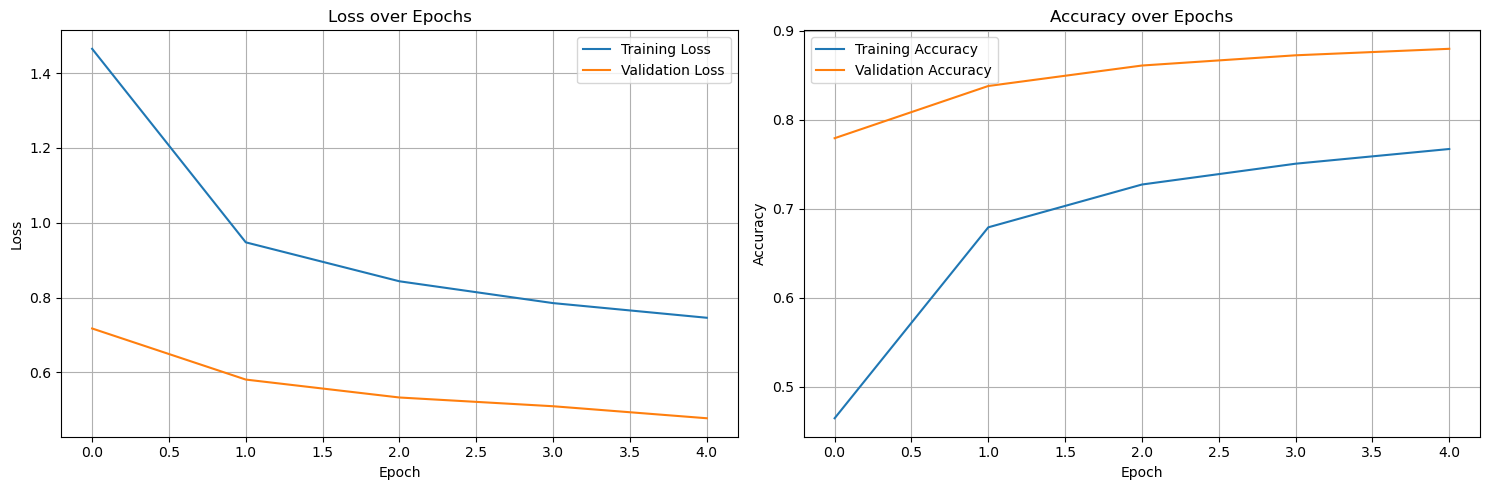

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(running_loss, label='Training Loss')
ax1.plot(running_test_loss, label='Validation Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)


ax2.plot(running_acc, label='Training Accuracy')
ax2.plot(running_test_acc, label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)


plt.tight_layout()
plt.show()

## Tasca a fer

1. Seleccionar la funció de pèrdua a emprar per poder entrenar el model.
2. Afegir la validació al bucle del `MNIST` i contestar a la pregunta de si hi ha *overfitting*?
2. Crear dos objectes `DataLoader` pel següent [dataset](https://github.com/miquelmn/aa_2526/releases/download/pr3/p4.tar.gz). Per fer-ho haureu de primer descarregar les imatges de l'enllaç, i després carregar les dades emprant [ImageFolder](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) de `PyTorch`.
3. Entrenar un **MLP** amb `PyTorch` per tal d'identificar les classes. Prova primer amb una mida d'imatges més petita (64 per 64 píxels) fins a la mida original.

In [39]:
import os, glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn

# 1) Build a CONSISTENT class_to_idx from BOTH dirs (sorted)
def build_class_to_idx(*roots):
    classes = set()
    for rd in roots:
        for f in os.listdir(rd):
            if os.path.isdir(os.path.join(rd, f)):
                classes.add(f)
    classes = sorted(classes)  # enforce order
    return {c: i for i, c in enumerate(classes)}, classes

train_dir = '/Users/dylancanning/Desktop/UIB/AprenentatgeAutomatic/aa_2526/04_Imatges/export/test'
val_dir   = '/Users/dylancanning/Desktop/UIB/AprenentatgeAutomatic/aa_2526/04_Imatges/export/train'
# ^ double-check these aren’t swapped by mistake; usually train=.../train, val=.../val

class_to_idx, class_names = build_class_to_idx(train_dir, val_dir)
print("Classes:", class_names, "Mapping:", class_to_idx)

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx

        self.image_paths, self.labels = [], []
        # iterate classes in a fixed order
        for cls in class_to_idx.keys():
            pattern = os.path.join(root_dir, cls, '*.png')
            img_paths = sorted(glob.glob(pattern))
            self.image_paths.extend(img_paths)
            self.labels.extend([class_to_idx[cls]] * len(img_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# 2) Better transforms (Resize -> ToTensor -> Normalize)
transform_train = T.Compose([
    T.Resize((64, 64)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

transform_val = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_dataset = CustomImageDataset(train_dir, class_to_idx, transform_train)
val_dataset   = CustomImageDataset(val_dir,   class_to_idx, transform_val)

# 3) Shuffle TRAIN
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Classes: ['0', '4'] Mapping: {'0': 0, '4': 1}


In [40]:
train_dir = '/Users/dylancanning/Desktop/UIB/AprenentatgeAutomatic/aa_2526/04_Imatges/export/test'
val_dir = '/Users/dylancanning/Desktop/UIB/AprenentatgeAutomatic/aa_2526/04_Imatges/export/train'


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])

train_dataset = CustomImageDataset(root_dir=train_dir, transform=transform)
val_dataset = CustomImageDataset(root_dir=val_dir, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

TypeError: CustomImageDataset.__init__() missing 1 required positional argument: 'class_to_idx'

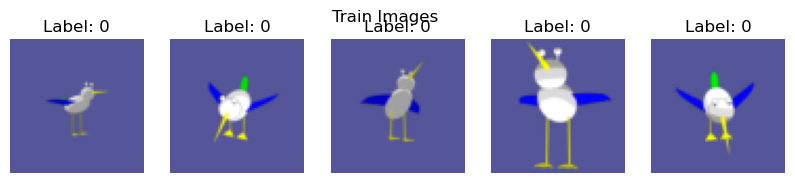

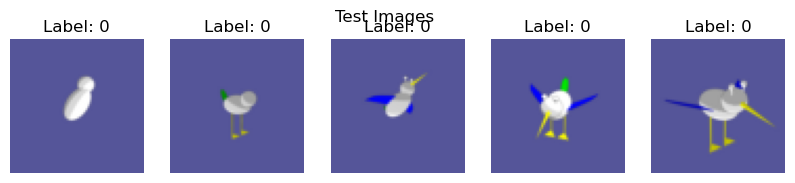

In [42]:
import matplotlib.pyplot as plt
import PIL

def show_images_from_dataloader(dataloader, title, n_images=5):
    images_shown = 0
    plt.figure(figsize=(n_images * 2, 2))
    for batch, labels in dataloader:
        for i in range(min(n_images, batch.shape[0])):
            img = batch[i].permute(1, 2, 0).numpy()
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.axis('off')
        break
    plt.suptitle(title)
    plt.show()

show_images_from_dataloader(train_dataloader, "Train Images")
show_images_from_dataloader(val_dataloader, "Test Images")


In [16]:
img.shape

torch.Size([1, 28, 28])

In [43]:
class ResidualMLPBlock(nn.Module):
    def __init__(self, d_in, d_hidden, p=0.3):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.act = nn.GELU()
        self.drop = nn.Dropout(p)
        self.fc2 = nn.Linear(d_hidden, d_in)
        self.ln = nn.LayerNorm(d_in)

    def forward(self, x):
        # Pre-norm + residual
        h = self.ln(x)
        h = self.fc1(h)
        h = self.act(h)
        h = self.drop(h)
        h = self.fc2(h)
        return x + h

class BirdMLP(nn.Module):
    def __init__(self, n_classes=2, in_dim=3*64*64, width=1024, p=0.35):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Linear(in_dim, width),
            nn.GELU(),
            nn.Dropout(p),
        )
        self.blocks = nn.Sequential(
            ResidualMLPBlock(width, int(width*2), p),
            ResidualMLPBlock(width, int(width*2), p),
            ResidualMLPBlock(width, int(width*1.5), p),
        )
        self.head = nn.Sequential(
            nn.LayerNorm(width),
            nn.Linear(width, 512),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(512, n_classes)  # 2 logits -> use CrossEntropyLoss
        )

    def forward(self, x):  # x: (B, 3, 64, 64)
        x = x.view(x.size(0), -1)  # flatten
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

model = BirdMLP(n_classes=2, in_dim=1*28*28, width=1024, p=0.35)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


In [44]:
def train_2():
    epoch_loss = 0
    correct_preds = 0
    model.train() 

    
    for x, y in train_dataloader:
        x = x.view(x.shape[0], -1)
        
        optimizer.zero_grad()
        output = model(x)
        batch_loss = loss_fn(output, y)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        correct_preds += get_correct_predictions(output, y)

    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_accuracy = correct_preds / len(train_dataloader.dataset)


    
    return avg_epoch_loss, epoch_accuracy

def validate_2():
    epoch_loss = 0
    correct_preds = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.view(x.shape[0], -1)

            output = model(x)
            epoch_loss += loss_fn(output, y).item()
            correct_preds += get_correct_predictions(output, y)

    
    avg_epoch_loss = epoch_loss / len(val_dataloader)
    epoch_accuracy = correct_preds / len(val_dataloader.dataset)
  
    return avg_epoch_loss, epoch_accuracy

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BirdMLP(n_classes=2, in_dim=3*64*64, width=1024, p=0.35).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

for epoch in range(10):
    model.train()
    tr_loss = tr_acc = 0.0
    for x, y in train_loader:
        x, y = x.to(device), torch.as_tensor(y, dtype=torch.long, device=device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * x.size(0)
        tr_acc  += (logits.argmax(1) == y).sum().item()

    model.eval()
    va_loss = va_acc = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), torch.as_tensor(y, dtype=torch.long, device=device)
            logits = model(x)
            loss = criterion(logits, y)
            va_loss += loss.item() * x.size(0)
            va_acc  += (logits.argmax(1) == y).sum().item()

    print(f"Epoch {epoch:02d} | "
          f"Train: loss {tr_loss/len(train_dataset):.3f}, acc {tr_acc/len(train_dataset):.3f} | "
          f"Val:   loss {va_loss/len(val_dataset):.3f}, acc {va_acc/len(val_dataset):.3f}")


Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=90, pipe_handle=137)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=90, pipe_handle=130)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
  File "/opt/anaconda3/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    

RuntimeError: DataLoader worker (pid(s) 3480, 3481) exited unexpectedly

In [29]:

img_path = '/Users/dylancanning/Desktop/UIB/AprenentatgeAutomatic/aa_2526/04_Imatges/export/test/4/000044.png'
img_path_2 = '/Users/dylancanning/Desktop/UIB/AprenentatgeAutomatic/aa_2526/04_Imatges/export/test/0/000004.png'

img = Image.open(img_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0)

img_2 = Image.open(img_path_2).convert('RGB')
img_tensor_2 = transform(img_2).unsqueeze(0)

img_tensor_flat_2 = img_tensor_2.view(1, -1)
img_tensor_flat = img_tensor.view(1, -1)


model.eval()

output_2 = model(img_tensor_flat_2)
output_1 = model(img_tensor_flat)
pred_class = torch.argmax(output_1, dim=1).item()
pred_class_2 = torch.argmax(output_2, dim=1).item()
print(f'Predicted class 1: {pred_class}')
print(f'Predicted class 2: {pred_class_2}')


Predicted class 1: 1
Predicted class 2: 1
